In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas numpy scikit-learn joblib


DECISION TREE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load and prepare the dataset
data1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Copy of Merged_UniSolar_Data_Interpolated.csv', nrows=800000)

# Map months to numeric values
month_mapping = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5,
    'June': 6, 'July': 7, 'August': 8, 'September': 9,
    'October': 10, 'November': 11, 'December': 12
}
data1['Month'] = data1['Month'].map(month_mapping).astype('category')

# Categorize the target variable
bins = [0, 20, 60, float('inf')]
labels = ['Low', 'Medium', 'High']
data1['GenerationCategory'] = pd.cut(data1['MaxSolarGeneration'], bins=bins, labels=labels, right=False).astype('category')

# Select features and target
feature_columns = [
    'AirTemperature', 'DewPointTemperature', 'RelativeHumidity',
    'WindSpeed', 'WindDirection', 'Year', 'Month'
]
X = data1[feature_columns]
y = data1['GenerationCategory']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=np.number))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=np.number))

# Append non-numeric columns after scaling
X_train_scaled = np.hstack([X_train_scaled, X_train.select_dtypes(exclude=np.number)])
X_test_scaled = np.hstack([X_test_scaled, X_test.select_dtypes(exclude=np.number)])

# Train the Random Forest model
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Predict for new data
new_data = pd.DataFrame({
    'AirTemperature': [25],
    'DewPointTemperature': [10],
    'RelativeHumidity': [50],
    'WindSpeed': [5],
    'WindDirection': [180],
    'Year': [2024],
    'Month': [11]
})

# Map 'Month' column to numeric value
new_data['Month'] = new_data['Month'].map(month_mapping).astype('category')

# Normalize new data
new_data_scaled = scaler.transform(new_data.select_dtypes(include=np.number))

# Ensure the new data has the same columns as the training data
new_data_processed = np.hstack([new_data_scaled, new_data.select_dtypes(exclude=np.number)])

# Make prediction
predicted_output = model.predict(new_data_processed)
print("\nPredicted Generation Category for New Location:", predicted_output[0])



Classification Report:
               precision    recall  f1-score   support

        High       0.12      0.03      0.05     26689
         Low       0.59      0.89      0.71     92383
      Medium       0.18      0.07      0.10     40928

    accuracy                           0.53    160000
   macro avg       0.30      0.33      0.29    160000
weighted avg       0.41      0.53      0.44    160000

Accuracy Score: 0.53411875

Predicted Generation Category for New Location: Low


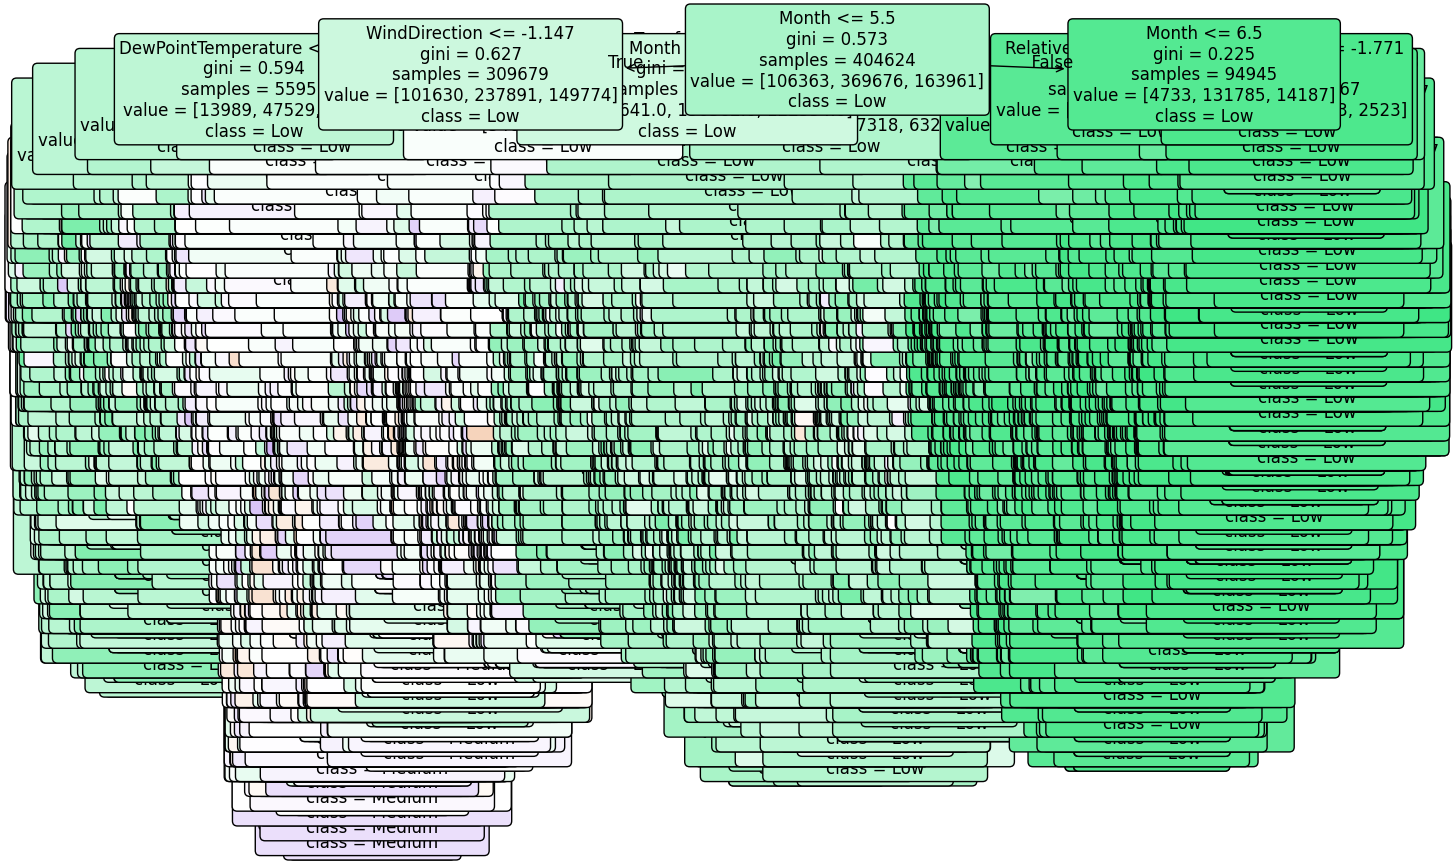


Predicted Generation Category for Custom Input: Low


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Define custom input as a dictionary with modified values to predict "High"
custom_input = {
    'AirTemperature': 25,     # Higher air temperature
    'DewPointTemperature': 10,
    'RelativeHumidity': 50,   # Moderate humidity
    'WindSpeed': 5,           # Moderate wind speed
    'WindDirection': 180,     # Wind direction
    'Year': 2024,
    'Month': 11               # November
}

# Convert the custom input into a DataFrame
custom_input_df = pd.DataFrame([custom_input])

# Map 'Month' column to numeric value
custom_input_df['Month'] = custom_input_df['Month'].map(month_mapping).astype('category')

# Normalize the custom input
custom_input_scaled = scaler.transform(custom_input_df.select_dtypes(include=np.number))

# Ensure the new data has the same columns as the training data
custom_input_processed = np.hstack([custom_input_scaled, custom_input_df.select_dtypes(exclude=np.number)])

# Get the first decision tree from the trained Random Forest model
tree = model.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(tree, filled=True, feature_names=feature_columns, class_names=model.classes_, rounded=True, fontsize=12)
plt.title("Decision Tree from Random Forest Model")
plt.show()

# Make prediction for custom input
predicted_category = model.predict(custom_input_processed)
print(f"\nPredicted Generation Category for Custom Input: {predicted_category[0]}")


In [ ]:
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])


Number of rows: 15614298
Number of columns: 14


In [ ]:
print(15614298*.75)

11710723.5


NAIVE BAYES

Accuracy of Bagging Classifier for MaxSolarCategory: 1.00

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00    243515
         Low       1.00      1.00      1.00   1790213
      Medium       1.00      1.00      1.00    308417

    accuracy                           1.00   2342145
   macro avg       1.00      1.00      1.00   2342145
weighted avg       1.00      1.00      1.00   2342145



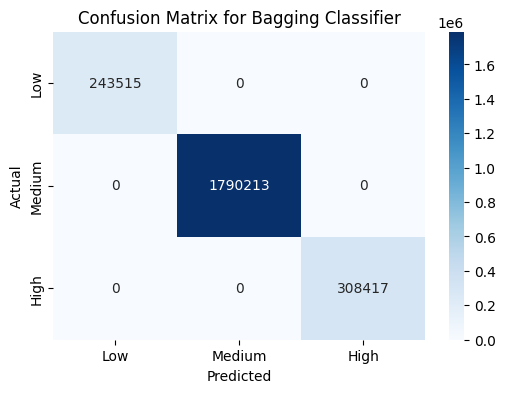

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Copy of Merged_UniSolar_Data_Interpolated.csv', nrows=11710723)

# Handle missing values in 'DataStatus'
data = data.dropna(subset=['DataStatus'])
data['DataStatus'] = data['DataStatus'].astype(int)

# Step 2: Categorize `MaxSolarGeneration` into High, Medium, and Low
def categorize_solar(value):
    if value < 20:  # Adjust thresholds as needed
        return "Low"
    elif value < 50:
        return "Medium"
    else:
        return "High"

data['MaxSolarCategory'] = data['MaxSolarGeneration'].apply(categorize_solar)

# Step 3: Apply Bagging to predict `MaxSolarCategory`
X_bagging = data.drop(columns=['MaxSolarCategory', 'Month', 'DataStatus', 'ApparentTemperature', 'AverageSolarGeneration', 'MinSolarGeneration'])  # Dropping unrelated columns
X_bagging = pd.get_dummies(X_bagging, drop_first=True)  # Encode categorical variables
y_bagging = data['MaxSolarCategory']

# Split the data
X_train_bagging, X_test_bagging, y_train_bagging, y_test_bagging = train_test_split(X_bagging, y_bagging, test_size=0.2, random_state=42)

# Train the Bagging model
bagging_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_model.fit(X_train_bagging, y_train_bagging)

# Evaluate the model
y_pred_bagging = bagging_model.predict(X_test_bagging)
accuracy_bagging = accuracy_score(y_test_bagging, y_pred_bagging)
print(f"Accuracy of Bagging Classifier for MaxSolarCategory: {accuracy_bagging:.2f}")

# Detailed evaluation
print("\nClassification Report for Bagging Classifier:")
print(classification_report(y_test_bagging, y_pred_bagging))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_bagging, y_pred_bagging)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix for Bagging Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy of Naive Bayes for MaxSolarCategory: 0.98

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

        High       0.99      1.00      0.99    243515
         Low       0.97      1.00      0.99   1790213
      Medium       1.00      0.83      0.91    308417

    accuracy                           0.98   2342145
   macro avg       0.99      0.94      0.96   2342145
weighted avg       0.98      0.98      0.98   2342145



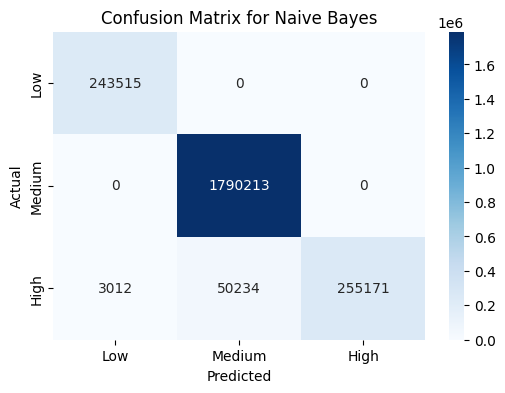

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

# Train the Naive Bayes model
nb_model.fit(X_train_bagging, y_train_bagging)

# Make predictions with Naive Bayes
y_pred_nb = nb_model.predict(X_test_bagging)

# Evaluate the Naive Bayes model
accuracy_nb = accuracy_score(y_test_bagging, y_pred_nb)
print(f"Accuracy of Naive Bayes for MaxSolarCategory: {accuracy_nb:.2f}")

# Detailed evaluation for Naive Bayes
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test_bagging, y_pred_nb))

# Confusion Matrix for Naive Bayes
conf_matrix_nb = confusion_matrix(y_test_bagging, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Define custom input as a dictionary
custom_input_nb = {
    'CampusKey': 1,
    'AirTemperature': 14.5,
    'DewPointTemperature': 10.0,
    'RelativeHumidity': 65.0,
    'WindSpeed': 1.5,
    'WindDirection': 170.0,
    'Year': 2021,
    'SiteKey': 3.0,
}

custom_input_nb_df = pd.DataFrame([custom_input_nb])

custom_input_nb_df = pd.get_dummies(custom_input_nb_df, drop_first=True)

custom_input_nb_df = custom_input_nb_df.reindex(columns=X_bagging.columns, fill_value=0)

predicted_maxsolarcategory = nb_model.predict(custom_input_nb_df)
print(f"Predicted MaxSolarCategory for custom input: {predicted_maxsolarcategory[0]}")


Predicted MaxSolarCategory for custom input: Low


In [ ]:
# Define custom input as a dictionary with adjusted values
custom_input_nb = {
    'CampusKey': 1,
    'AirTemperature': 90.0,
    'DewPointTemperature': 90.0,
    'RelativeHumidity': 10.0,
    'WindSpeed': 4.0,
    'WindDirection': 150.0,
    'Year': 2021,
    'SiteKey': 3.0,
}

# Convert the custom input into a DataFrame
custom_input_nb_df = pd.DataFrame([custom_input_nb])

# Apply one-hot encoding to categorical variables (if any)
custom_input_nb_df = pd.get_dummies(custom_input_nb_df, drop_first=True)

# Align columns with the training data
custom_input_nb_df = custom_input_nb_df.reindex(columns=X_bagging.columns, fill_value=0)

# Make a prediction using the trained Naive Bayes model
predicted_maxsolarcategory = nb_model.predict(custom_input_nb_df)
print(f"Predicted MaxSolarCategory for custom input: {predicted_maxsolarcategory[0]}")


Predicted MaxSolarCategory for custom input: Medium
